In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np
import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import defmod.registrationdata as regdata

torch.set_default_tensor_type(torch.DoubleTensor)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
dim = 2
origin = [[0.,0.], [10.,0.]]
radius = [2., 1.]
nb_pts = [10, 7]

data = regdata.PointCircles()
#data(nb_pts, origin, radius, transvec = [[10., 0.], [-10.,0.]], scal=1)
data(nb_pts, origin, radius, transvec = [[0., 5.], [0.,-5.]], scal=1)


source = data.source
target = data.target

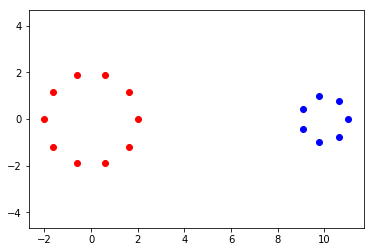

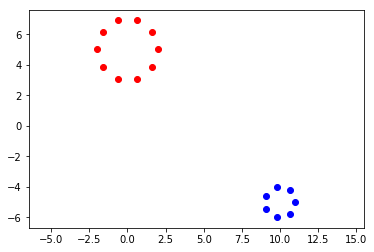

In [3]:
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

plt.figure()
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
# Defining the deformation modules
sigma1 = 3
manifold1 = dm.manifold.Landmarks(dim, nb_pts[0], gd=source[0].view(-1))
trans1 = dm.deformationmodules.Translations(manifold1, sigma1)

#trans1 = dm.deformationmodules.GlobalTranslation(manifold1, sigma1)
# constraints with global translation not working

sigma2 = 3
manifold2 = dm.manifold.Landmarks(dim, nb_pts[1], gd=source[1].view(-1))
trans2 = dm.deformationmodules.Translations(manifold2, sigma2)
#trans2 = dm.deformationmodules.GlobalTranslation(manifold2, sigma2)

module_list = [trans1, trans2]
sigma_bg = 0.1

modules = dm.multishape.MultiShapeModule(module_list, sigma_bg)

In [5]:
modules.manifold.fill_cotan([torch.rand(dim*nb_pts[0]), torch.rand(dim*nb_pts[1]), [torch.rand(dim*nb_pts[0]), torch.rand(dim*nb_pts[1])]])

In [6]:
constr_Id = dm.constraints.Identity()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [7]:
my_model = dm.models.ModelMultishapePointsRegistration(source, [trans1, trans2], sigma_bg,  dm.attachement.L2NormAttachement_multi(), constr_Id)
costs = my_model.fit(target, lr=1e-4, l=1e5, max_iter=200, log_interval=5)

It: 0, deformation cost: 14.045530, attach: 1272396.763294. Total cost: 1272410.808824
It: 5, deformation cost: 36.572211, attach: 863987.286216. Total cost: 864023.858427
It: 10, deformation cost: 52.284056, attach: 686907.475281. Total cost: 686959.759336
It: 15, deformation cost: 64.990453, attach: 566706.030934. Total cost: 566771.021388
It: 20, deformation cost: 74.994232, attach: 481494.845078. Total cost: 481569.839310
It: 25, deformation cost: 83.109901, attach: 417023.415774. Total cost: 417106.525675
It: 30, deformation cost: 89.847158, attach: 366130.226747. Total cost: 366220.073905
It: 35, deformation cost: 95.541987, attach: 324727.525501. Total cost: 324823.067488
It: 40, deformation cost: 100.425192, attach: 290281.103294. Total cost: 290381.528486
It: 45, deformation cost: 104.660888, attach: 261123.255569. Total cost: 261227.916457
It: 50, deformation cost: 108.369384, attach: 236104.124061. Total cost: 236212.493445
It: 55, deformation cost: 111.641316, attach: 21440

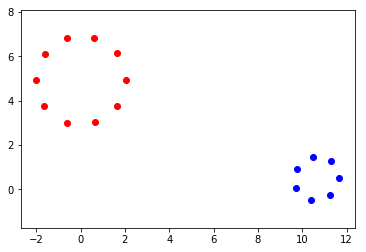

In [8]:
my_model.compute(target)
shot_gd = my_model()

plt.scatter(shot_gd[0].view(-1,2)[:, 0].detach().numpy(),shot_gd[0].view(-1,2)[:, 1].detach().numpy(), c='red')
plt.scatter(shot_gd[1].view(-1,2)[:, 0].detach().numpy(),shot_gd[1].view(-1,2)[:, 1].detach().numpy(), c='blue')
plt.axis('equal')
plt.show()

In [59]:
out = my_model()
%matplotlib qt5
#plt.subplot(1, 2, 1)
#dm.usefulfunctions.plot_tensor_scatter(target[0], alpha=0.4)
#dm.usefulfunctions.plot_tensor_scatter(source[0], alpha=0.4)
#ax = plt.subplot(1, 2, 2)
#dm.usefulfunctions.plot_tensor_scatter(target[0], alpha=0.4)
#dm.usefulfunctions.plot_tensor_scatter(out[0][0], alpha=0.4)
#plt.plot(my_model.shot_manifold[1].gd[0].detach().view(-1, 2)[:, 1].numpy(), my_model.shot_manifold[1].gd[0].detach().view(-1, 2)[:, 0].numpy(), '.')
#plt.plot(my_model.shot_manifold[2].gd[0].detach().view(-1, 2)[:, 1].numpy(), my_model.shot_manifold[2].gd[0].detach().view(-1, 2)[:, 0].numpy(), '.')
gridpos_x, gridpos_y = my_model.compute_deformation_grid(torch.tensor([-2, -2]), torch.tensor([12, 12]), torch.tensor([16, 16]))
dm.usefulfunctions.plot_grid(ax, gridpos_y.detach().numpy(), gridpos_x.detach().numpy(), color='C0')
plt.show()


TypeError: div(): argument 'other' (position 1) must be Tensor, not list

In [9]:
# Why??
print(H.module.manifold.gd[0].view(-1) - shot_gd[0].view(-1))
print(H.module.manifold.gd[1].view(-1) - shot_gd[1].view(-1))
print(H.module.manifold.gd[2][0].view(-1) - shot_gd[2][0].view(-1))
print(H.module.manifold.gd[2][1].view(-1) - shot_gd[2][1].view(-1))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SubBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SubBackward0>)
tensor([-4.1895e-02, -4.9465e+00, -1.7896e-02, -4.9487e+00, -9.8520e-03,
        -4.9408e+00, -1.3728e-02, -4.9360e+00, -3.9708e-03, -4.9454e+00,
         8.4963e-03, -4.9447e+00,  1.1098e-02, -4.9174e+00,  5.4325e-03,
        -4.9128e+00, -1.7780e-02, -4.9461e+00, -4.4696e-02, -4.9527e+00],
       grad_fn=<SubBackward0>)
tensor([-0.6673, -0.5254, -0.6853, -0.5079, -0.6876, -0.4935, -0.6601, -0.4866,
        -0.6281, -0.4905, -0.6256, -0.5100, -0.6459, -0.5287],
       grad_fn=<SubBackward0>)


In [9]:
grid_origin = [0,0]
grid_size = [10,10]
grid_resolution = [16, 16]

x, y = torch.meshgrid([
            torch.linspace(grid_origin[0], grid_origin[0]+grid_size[0], grid_resolution[0]),
            torch.linspace(grid_origin[1], grid_origin[1]+grid_size[1], grid_resolution[1])])

gridpos = dm.usefulfunctions.grid2vec(x, y)

grid_landmarks = dm.manifold.Landmarks(2, gridpos.shape[0], gd=gridpos.view(-1))
grid_silent = dm.deformationmodules.SilentPoints(grid_landmarks)
        
boundary_labels = [np.zeros(grid_landmarks.nb_pts), *[np.ones(mod.manifold.nb_pts) for mod in module_list]]
        
multi_silent = dm.multishape.MultiShapeModule([grid_silent, *module_list], sigma_bg, boundary_labels)

In [20]:
multi_silent.field_generator()[0](multi_silent.manifold.gd[0])

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [16]:
points = torch.rand([5,2])
multi_silent.compute_geodesic_variables(constr_Id)

controls shape torch.Size([0])
boundary 0.0
controls shape torch.Size([20])
boundary 10.0
controls shape torch.Size([14])
boundary 7.0


RuntimeError: invalid argument 8: lda should be at least max(1, 0), but have 0 at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/TH/generic/THBlas.cpp:330

In [10]:
hamiltonian_silent = dm.hamiltonian_multishape.Hamiltonian_multi(multi_silent, constr_Id)
intermediate = dm.shooting.shoot_euler(hamiltonian_silent, it=10)

controls shape torch.Size([0])
boundary 0.0
controls shape torch.Size([20])
boundary 10.0
controls shape torch.Size([14])
boundary 7.0


RuntimeError: invalid argument 8: lda should be at least max(1, 0), but have 0 at /opt/conda/conda-bld/pytorch_1544174967633/work/aten/src/TH/generic/THBlas.cpp:330

In [72]:
multi_silent.module_list[0].controls

tensor([], requires_grad=True)

In [73]:
multi_silent.module_list[0].manifold.dim_gd

(512,)

In [71]:
multi_silent.module_list[0].fill_controls_zero()

In [76]:
np.sum(boundary_labels[1])

10.0

In [77]:
[np.sum(labels) for labels in boundary_labels]

[0.0, 10.0, 7.0]

In [78]:
np.sum([np.sum(labels) for labels in boundary_labels])

17.0